# 3: Gene Expression Analysis Case Study

**Authors**: Michelle Franc Ragsac (mragsac@eng.ucsd.edu) and Clarence Mah (ckmah@ucsd.edu) 

**Credit**: Adapted from UCSD CMM262


In the last notebook for this module, we'll be walking through the fundamentals of RNA-sequencing analysis and learn how to create and interpret commonly-used plots in gene expression analysis.

## Case Study: Human Airway Smooth Muscle Transcriptome Changes in Response to Asthma Medications
> **Paper:** [Himes, Blanca E., et al. PloS one (2014)](https://pubmed.ncbi.nlm.nih.gov/24926665/)
> <br>**Data:** https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE52778

#### Rationale
Asthma is a chronic inflammatory airway disease. The most common medications used for its treatment are β2-agonists and glucocorticosteroids, and one of the primary tissues that these drugs target in the treatment of asthma is the airway smooth muscle. We used RNA-Seq to characterize the **human airway smooth muscle (HASM)** transcriptome at baseline and under three asthma treatment conditions.

## Table of Contents
1. [Importing the Gene Expression Data](#1.-Importing-the-Gene-Expression-Data-into-our-Jupyter-Notebook)
2. [Filtering Uninformative Genes](#2.-Filtering-Uninformative-Genes-on-counts-Table)
3. [Calculating the Total Reads Per Sample](#3.-Calculating-the-Total-Reads-Per-Sample-with-the-DataFrame.sum()-Method)
4. [The Log Transformation](#4.-The-Log-Transformation)
5. [Clustering Analysis](#5.-Clustering-Analysis-with-the-sns.clustermap()-Method)
6. [Determine Sample Similarity](#6.-Determine-Sample-Similarity)
7. [Differential Expression Analysis](#7.-Differential-Expression-Analysis-between-Untreated-and-Dexamethasone-treated-Samples)
8. [Analyzing the Results of Our Analysis: Are Our Results Real?](#8.-Analyzing-the-Results-of-Our-Analysis:-Are-Our-Results-Real?)

---

# 1. Importing the Gene Expression Data into our Jupyter Notebook

Gene expression data is commonly stored in a text file as a table: each row represents a gene and each column represents a sample or experiment. In our case, the file at `data/asm_dex_counts.txt` contains our gene expression read counts, and our file is formatted as a tab-separated text file. 

Let's spend this portion of the notebook importting any necessary packages we need for our analysis, along with our read counts table! 

### Import Python Packages for Our Analysis

In [ ]:
import pandas as pd     # we'll be using pandas for table manipulation
import numpy as np      # we'll be using numpy for numerical functions 

# We're also going to import seaborn and matplotlib for plotting functions
import seaborn as sns               
import matplotlib.pyplot as plt     

### Load RNA-Sequencing Read Counts Table from `data/asm_dex_counts.txt` using the `pd.read_table()` Method

Next, we'll be importing our table through the `pd.read_table()` method, which takes in the filepath as the first argument where your table is located. 

We'll also be taking advantage of the `index_col` parameter to set the `Name` variable to our `DataFrame`'s index (also known as the rows) names. 

In [ ]:
# Import the RNA-sequencing read counts table 
counts = pd.read_table('data/asm_dex_counts.txt', index_col='Name')

# Output the dimensions of the table to see how many genes we have (rows) versus how many columns (samples)
counts.shape

As a next step, let's also preview the `counts` `DataFrame` to take a sneak peak into what our table looks like! 

In [ ]:
counts.head()

<div class="alert alert-block alert-info">
    <b>Note:</b> Raw read counts will <b>always</b> be whole numbers! If you see anything otherwise in your table, you are dealing with read counts that have been <b>normalized</b> or <b>estimated</b>.
</div>

### Load Sample Annotations from the Experiment into `counts` using the `pd.read_table()` Method

Additional information will almost always accompany gene expression data, including variables like experimental treatment conditions, batch numbers, and sample names. We can use the same function as we did for loading the gene expression data (`pd.read_table()`) to load our sample annotations from a text file. This time, we'll set the `index_col` parameter to set the `sample` variable as our index (or row) names. An additional parameter, `squeeze=True`, will load the data as a `Series` object instead of a `DataFrame` object. 

In [ ]:
# Import the RNA-sequencing annotation information
labels = pd.read_table('data/asm_dex_labels.txt', index_col='sample', squeeze=True)

# Preview the contents of the labels variable
labels

For this experiment, there are 8 samples that are labeled either `untreated` or `Dex` to represent **dexamethoasone**. Dexamethoasone is a corticosteriod drug used to treat asthma among many other inflammatory conditions.

---

# 2. Filtering Uninformative Genes on `counts` Table

As a first step, it's good practice to examine the read distribution across all genes. We can then remove the unexpressed or lowly-expressed genes since they will be largely uninformative in further analysis. 

### Filter out Low Expression Genes (`<10 Reads`) with the `DataFrame.loc[]` Method

Within this step, we'll perform the following functions: 

1. Take the sum of each row to count the number of total reads per gene across all samples using the `DataFrame.sum()` method with the `axis` parameter set as `1` to sum across our rows
2. Next, we will generate a conditional statement to determine which genes have a read count greater than 10--we'll be keeping these reads in our dataset
3. Finally, we'll use the `DataFrame.loc[]` method to store rows that met our conditional statement. 

In [ ]:
# Take the sum of read counts per gene across each column with the sum() method 
# (By default, sum() sums across all rows for each column -- we've set axis=1 to perform the opposite function)
counts.sum(axis=1) 

In [ ]:
# Determine which genes have a read count >=10 reads after summing across our samples 
counts.sum(axis=1) >= 10

In [ ]:
print(f"The shape of our counts DataFrame before filtering: {counts.shape}")

# Subset our counts DataFrame to only keep these genes that have a read count >=10 using the DataFrame.loc[] method
counts = counts.loc[counts.sum(axis=1) >= 10]

print(f"The shape of our counts DataFrame after filtering: {counts.shape}")

By filtering out lowly-expressed genes, we are now left with **20,405** genes to work with versus **57,773** genes! 

### Saving Final Set of Genes and Samples to List Objects for Future Reference using the `Series.tolist()` Method

Now that we know what samples we're working with and what genes we're including in our analysis, let's save this information into list objects for easy reference later. 

We can access the list of row names for our `DataFrame` by accessing the `DataFrame.index` attribute, as well as the column names with the `DataFrame.columns` attribute. Within this section, we'll access our gene names (the index names, or row names) and sample names (the column names) then convert these into list objects using the `Series.tolist()` method. 

In [ ]:
# Save the list of genes within our counts DataFrame 
genes = counts.index.tolist()
print(f"There are {len(genes)} genes present in counts")

# Save the list of samples within our counts DataFrame
samples = counts.columns.tolist()
print(f"There are {len(samples)} samples present in counts")

---

# 3. Calculating the Total Reads Per Sample with the `DataFrame.sum()` Method

Within this method, we'll determine the number of total reads per sample with the `DataFrame.sum()` method (without setting the axis parameter this time). 

In [ ]:
# Determine the number of total reads per sample
sample_counts = counts.sum()

To visualize a handful of samples, we can use a bar plot where the samples are on the x-axis and our sample read count is on the y-axis! We can use the `sns.barplot()` method to generate our plot.

In [ ]:
# Generate a bar plot with our samples on the x-axis and total read counts on the y-axis 
sns.barplot(x=samples, y=sample_counts)

plt.ylabel('Read Counts') # label the y-axis

Now, let's spend some time to make our plot a little more pretty! 

We can color each sample's bar by the treatment condition by setting the `hue` parameter as `hue=labels`. Additionally, we can use `dodge=False` to format the bar widths (without it, the plot isn't very aesthetic...). 

In [ ]:
sns.barplot(x=samples, y=sample_counts, hue=labels, dodge=False)

plt.xlabel('Sample Name') # label the x-axis
plt.ylabel('Read counts') # label the y-axis
plt.title('Distribution of Total Read Counts') # label the entire plot 

---

# 4. The Log Transformation

Usually, gene expression counts are not normally distributed and are usually heavily right skewed. There are more genes that have very low read counts compared to high read counts, making for some ugly, unintuitive plots for raw counts! 

The **log-transformation** (usually $log_2$) helps to visualize things more meaningfully. Let's try visualizing what our raw read count distribution looks like before and after log-transforming our data! 

### Visualizing the Raw Read Count Distribution Before Log-Transformation

Let's first plot a single sample, `A`, as a histogram to see what the plot looks like.

In [ ]:
# Plot a histogram of the raw counts for sample A with 100 bins 
sns.histplot(data=counts['A'], bins=100)

As you can see, this plot is *extremely* skewed to the right! 

#### Box Plots

As a comparison, let's plot a box plot for each sample. 

Let's plot a boxplot for each sample. Notice how many points are outside the interquartile range (genes with really big counts).

In [ ]:
sns.boxplot(data=counts)

In our box plots, notice how many points are *outside* the interquartile range; these are genes with very large raw counts. 

#### Heatmaps

Next, let's make a heatmap, where rows represent our genes and our columns represent our samples.

In [ ]:
# We are using a color gradient called 'RdBu_r' which stands for 
# "red blue reversed" to code values in the heatmap.
# "Reversed" switches the direction of the gradient.
sns.heatmap(data=counts, cmap='RdBu_r')

In our heatmap, notice how almost *nothing* is visible. Without transforming our heavily-skewed data, there isn't any way to visualize any trends that may exist within our samples and the different conditions! 

### Visualizing the Log-Transformed Read Count Distribution 

Now that we're done plotting what our data looks like *before* performing any log-transformations, let's take $log_2$ of our counts, which will transform the data so it resembles more of a normal distribution. The full transformation we perform is $log_2(counts+1)$.

<div class="alert alert-block alert-info">
    <p><b>Note:</b> The addition of <code>1</code> is commonly referred to as adding a <b>pseudocount</b>. This pseudocount is usually a negligible amount added to all values to ensure that they are greater than 0, which allows us to apply a log-transformation.</p>
</div>

In [ ]:
# Use the np.log2() function to apply log2 to every value in the counts DataFrame
log_counts = np.log2(counts+1)

#### Histograms and Box Plots

Now that we have our transformed data, we'll leave it up to you to generate the histogram of a single sample as well as a box plot across all samples to compare what our transformed distribution looks like against the untransformed values! 

<div class="alert alert-block alert-success">
    <p><b>Exercise:</b> Let's plot the sample `A` as a histogram again. A roughly bell-shaped curve is now visible. This is what you  should expect a standard RNA-seq experiment to looks like.</p>
</div>

<div class="alert alert-block alert-info">
    <p><b>Note:</b> Next week we will go over why we can't make the assumption that gene expression is normally distributed. But for the purpose of this analysis, we will keep this simplified assumption for now.</p>
</div>

In [ ]:
# TODO

<div class="alert alert-block alert-success">
    <p><b>Exercise:</b> Again, let's plot a boxplot for each sample. The quartiles should be clearly visible and the number of outliers have been greatly reduced thanks to the log transformation.</p>
</div>


In [ ]:
# TODO

#### Violin Plots

Violin plots are another commonly-used plot to view distributions. It's a combination of a box plot and a density plot. The advantage of a violin plot over a box plot is that they allow you to better visualize the underlying distribution that may be present in your data. With box plots alone, they cannot easily visualize the true distribution of one's data, especially if it's bimodal. 

In [ ]:
# Create a violin plot of the log-transformed counts 
sns.violinplot(data=log_counts)

#### Heatmaps

<div class="alert alert-block alert-success">
    <p><b>Exercise:</b> Let's create a heatmap again; Now we can start to visually distinguish patterns between genes and samples.</p>
</div>

In [ ]:
# TODO

# 5. Clustering Analysis with the `sns.clustermap()` Method

Heatmaps are an efficient way to visualize and compare expression values across genes and samples simultaneously! 

A common approach to clustering, or grouping values by similarity, is **hierarchical clustering**. We can use the `sns.clustermap()` method to easily cluster our samples (columns) and genes (columns) for striking visualizations that might tell us more about what sets of genes have similar expression profiles, and what samples are similar to each other! The `sns.clustermap()` method takes in several parameters: 

* **`data`**: the `DataFrame` that we want to plot data points from
* **`col_cluster`**: can be set as `True` if you would like to cluster across the columns, or `False` if you do not want to cluster across columns
* **`row_cluster`**: can be set as `True` if you would like to cluster across the rows, or `False` if you do not want to cluster across rows
* **`xticklabels`**: can be set as `True` if you would like to display tickmark labels on the x-axis 
* **`yticklabels`**: can be set as `True` if you would like to display tickmark labels on the y-axis (*This value is usually set to `False` as we often have too many genes to label!*)
* **`cmap`**: sets the color map for the heatmap (You can find more information here: https://seaborn.pydata.org/tutorial/color_palettes.html)

For this section, we'll start off by just clustering the **rows** for our data to see which genes have similar expression profiles across our samples! 

In [ ]:
sns.clustermap(data=log_counts,
               col_cluster=False,
               row_cluster=True,
               xticklabels=True,
               yticklabels=False, # Hide row ticklabels, too many to view at once
               cmap='RdBu_r')

With our `cmap` parameter, we've set it so that **low values are dark blue** and **high values are dark red**. With this visualization, we can see there are approximately three groups of gene expression profiles that our genes can have: those in the lowest tier of expression (dark blue), those with mid-range expression values (light blue to pale blue/white), and those with high expression (pale red)! 

<div class="alert alert-block alert-info">
    <p><b>Note:</b> In generating <i>any</i> figures or visualizations for your data, it's important to consider the accessibility of your plots and the presentation of your data as a whole! There are a variety of ways to make your data visualizations accessible, from making things colorblind-friendly, to making things easier more legible, to making things culturally sensitive. The US General Accessibility Services office has a decent introduction to making visual design accessible if you're interested in reading more about this topic: < a href="https://accessibility.digital.gov/visual-design/getting-started/">https://accessibility.digital.gov/visual-design/getting-started/</a></p>
</div>

As a next step, we can label our samples with our different treatment conditions. We can grab a color palette to label our samples with using the `sns.color_palette()` method! 

In [ ]:
# Let's get a color palette with seaborn so we can label our samples with different colors! 
palette = sns.color_palette('tab10')

# Print what our palette looks like 
palette

Now, we can assign each unique condition with a different color using the code in the block below.

In [ ]:
# labels.unique()               - determines the unique set of labels that we need colors for
# zip(labels.unique(), palette) - associates a unique label to one of the colors in the palette we've chosen
# dict(...)                     - generates a dictionary object where our keys are the labels and our values are the colors

label2color = dict(zip(labels.unique(), palette))

In [ ]:
# We can then use the map() method to look up each sample's color in the dictionary we created
label_color = labels.map(label2color)

Finally, now that we have all of our colors set up, let's color each sample by its condition in our clustered heatmap! 

In [ ]:
ax = sns.clustermap(data=log_counts,
                    col_cluster=False,
                    row_cluster=True,
                    xticklabels=True, 
                    yticklabels=False,      # Hide row ticklabels, too many to view at once
                    col_colors=label_color, # Pass the colors we just assigned to each sample
                    cmap='RdBu_r')

# Create a legend in the top right -- just ignore this for now!
from matplotlib.patches import Patch
handles = [Patch(facecolor=label2color[name]) for name in labels.unique()]
plt.legend(handles, label2color, title='Condition',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

<div class="alert alert-block alert-success">
    <p><b>Exercise:</b> In addition to clustering genes, cluster the samples as well. Start by copying the previous cell and changing the appropriate parameter to cluster columns.</p>
</div>

In [ ]:
# TODO

And with this, we're finally done with our clustering analysis! 

Give yourself a pat on the back! You just created a complex, yet informative figure! 

---

# 6. Determine Sample Similarity

## Calculating Correlation Between Samples with `sns.regplot()` and `scipy.stats.pearsonr()` Methods

Scatterplots are another useful way to visualize the similarity and correlation between samples. We can generate scatterplots where each point represents a gene, and we can see how that point is positioned between two samples; we can also calculate a correlation value! The higher the correlation value, the more similar the two samples are. 

<div class="alert alert-block alert-info">
    <p><b>Note:</b> We usually expect or hope to see the following trend when inspecting sample correlation: replicates > sample type > treatment condition.</p>
</div>

In [ ]:
# Let's start out by importing the stats module from the scipy package
from scipy import stats

As an example, let's calculate and plot the correlation between sample `A` (untreated) vs sample `E` (dexamethasone). 

In [ ]:
# Set the figure size to 6 x 6
plt.figure(figsize=(6,6))

# Scatter plot and Linear regression line fit to the data
sns.regplot(data=log_counts, # specify the DataFrame
            x='A', # plot sample A on the x-axis
            y='E', # plot sample E on the y-axis
            scatter_kws={'s': 3}, # set point size = 3px
            line_kws={'color': 'black'})  # set line color to black

r, p_value = stats.pearsonr(log_counts['A'], log_counts['E']) # calculate pearson correlation and p-value
plt.legend([f'r = {r:.2f}']) # put correlation on legend, formatted to 2 decimal places

From the code block above, we can see that the correlation between sample `A` and sample `E` is `0.98`, meaning that these two samples are very highly correlated.

Instead of plotting each pairwise combination one by one, we can also calculate all pairwise sample correlations with the `DataFrame.corr()` function. By default, this method calculates the correlation between the **columns** of our `DataFrame`. 

In [ ]:
# Calculate the correlation between all pairwise combinations of our samples with the corr() method
counts.corr()

<div class="alert alert-block alert-success">
    <p><b>Exercise:</b> Plot the sample correlation values in a heatmap. Cluster the rows and columns and plot the treatment condition colors like we did previously.</p>
</div>

In [ ]:
# TODO

## Performing Principal Component Analysis (PCA) to Visualize Samples

Principal component analysis (PCA) is a technique used to emphasize variation and bring out strong patterns in a dataset. It's often used to make data easy to explore and visualize. PCA is a fundamental **dimensionality reduction** technique.

Here's a link to an amazing visual resource: https://setosa.io/ev/principal-component-analysis/. 

![Input and corresponding PCA output](img/day2_pca.png)

Let's start out by importing the PCA module from the `sklearn` package.

In [ ]:
from sklearn.decomposition import PCA

The PCA analysis prefers to have samples as rows and features as columns. 

We can flip/transpose our `log_counts` DataFrame to match this requirement by accessing the `DataFrame.T` attribute.

In [ ]:
log_counts.T

Now we can perform the transformation to transform our samples into **2-dimensional** sapce instead of **20405-D** space (where `20405` comes from the number of genes we have)!

In [ ]:
# Create a PCA object and call the fit_transform function.
# Setting n_components=2 means only the first 2 components are calculated
principal_components = PCA(n_components=2).fit_transform(log_counts.T) 

# For convenience, we can format this as a DataFrame object 
principal_components = pd.DataFrame(principal_components)

# Display the results of our principal components analysis
principal_components

In these results, each column is a principal component (in this case, only the first 2 PCs)!

#### Plot Our Samples in Principal Component Space

Now that we've calculated our principal components, we can plot them using the `sns.scatterplot()` method to see how similar samples are to each other! 

In [ ]:
sns.scatterplot(x=principal_components[0],
                y=principal_components[1],
                hue=labels.values) # color samples by treatment condition

Within this plot, we can see that untreated samples tend to be closer together, while dexamethasone-treated samples are closer together.

---

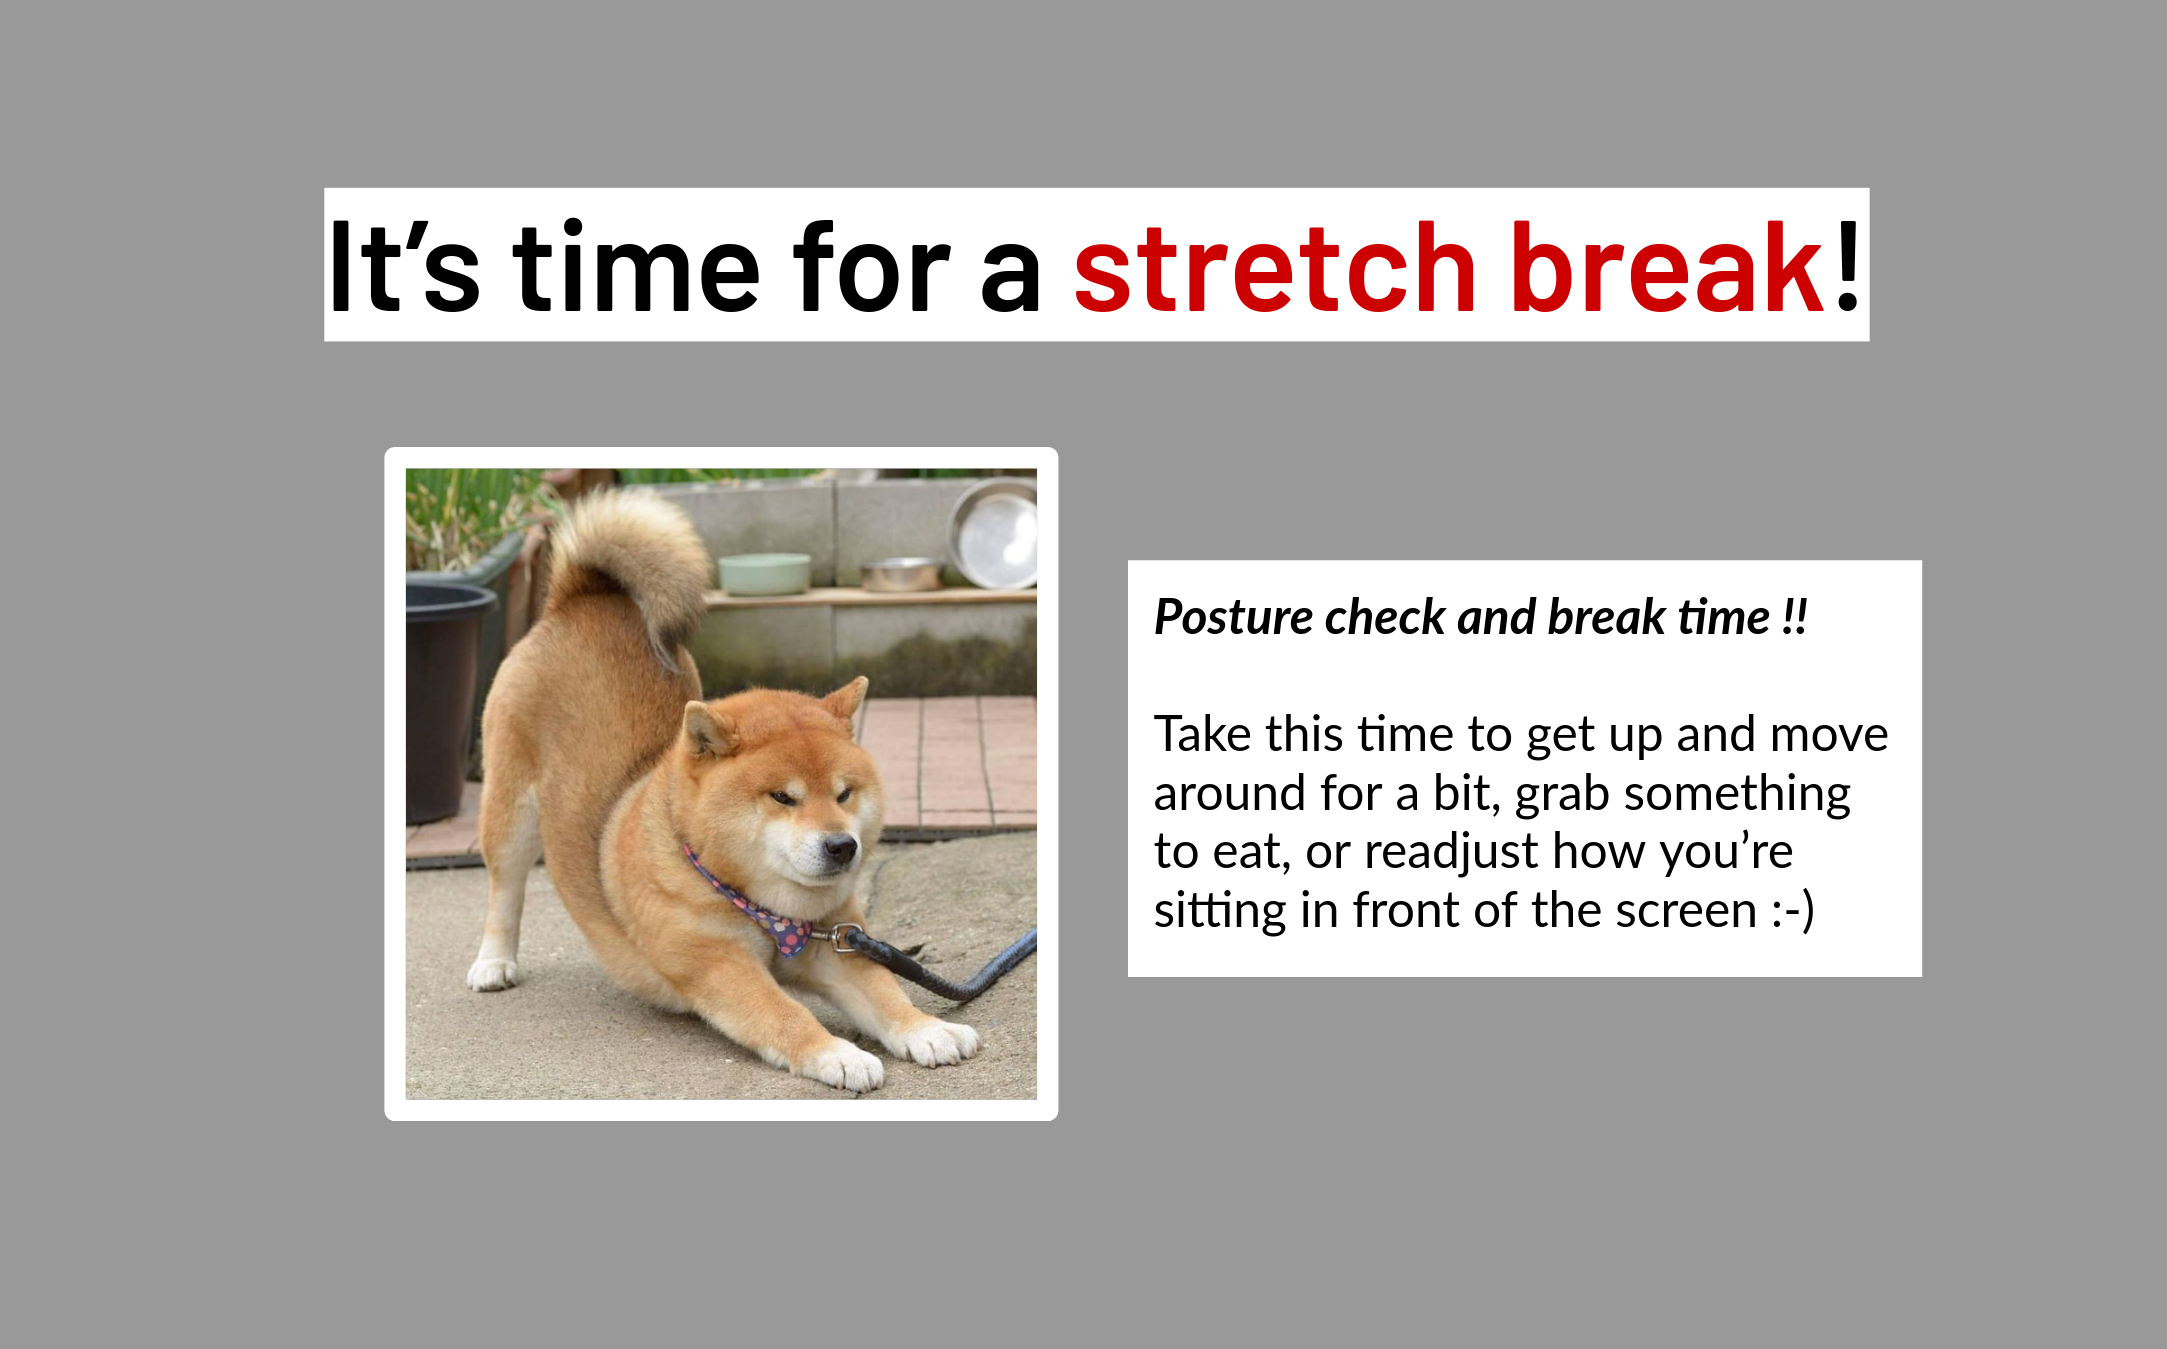

---

# 7. Differential Expression Analysis between Untreated and Dexamethasone-treated Samples

Differential Expression (DE) analysis can boil down to identifying a **statistically significant** change in expression between two conditions. For now, we will use the simplest model possible for the DE analysis on our treated versus untreated samples: the two-sample t-test! We perform a t-test on the expression levels of each gene in our log-transformed counts matrix, comparing `Dexamethasone` to `untreated` samples.

<div class="alert alert-block alert-info">
    <p><b>Note:</b> Next week, we will be learning moure about <b>DESeq2</b>, a bioinformatics tool in R that is widely regarded as the gold standard for differential expression analysis. It uses the same concepts covered here, albeit using more appropriate statistical models (Negative Binomial distribution).</p>
</div>

First, let's select all of our untreated samples (labeled as `untreated`) and all of our dexamethasone-treated samples (labeled as `dex`). 

In [ ]:
# Select all of our untreated samples that we have in our data
untreated_counts = log_counts.loc[:,labels == 'untreated']

# Preview the untreated samples in our dataset
untreated_counts.head()

In [ ]:
# Select all of our treated samples that we have in our data
dex_counts = log_counts.loc[:,labels == 'Dex']

# Preview the treated samples in our dataset
dex_counts.head()

Now, let's perform a t-test **for each gene** (over 20,000 tests!).

In [ ]:
# Perform a t-test on each gene then format the results into a DataFrame object
ttest_results = stats.ttest_ind(dex_counts.T, untreated_counts.T) 
ttest_results = pd.DataFrame(ttest_results).T 

# Name the columns and row names nicely
ttest_results.columns = ['t_stat', 'p_value'] 
ttest_results.index = genes 

# Preview the results table
ttest_results.head()

We're done with performing the t-test and we were able to get the t-statistic and our p-value for each gene! However, we have to perform yet *another* step because we are performing thousands of tests. 

### Performing Multiple Testing Correction on our T-Test Results

Because we are performing thousands of tests, many of our significant results will occur simply by chance. Multiple testing correction **reduces** the number of false positives in our data according to our defined significance threshold. We will use an `alpha = 0.05`.

In [ ]:
# Start off by importing the multiple testing correction package 
from statsmodels.stats.multitest import multipletests

In [ ]:
# Copy the t test results to a new DataFrame
diff_results = ttest_results.copy()

# Perform multiple testing correction on p-values
mult_test_results = multipletests(ttest_results['p_value'], alpha=0.05, method="fdr_bh")

# Save which genes pass our significance threshold of 0.05
diff_results['significance'] = mult_test_results[0]

# Save the corrected p-values
diff_results['p_corrected'] = mult_test_results[1]

# Save -log10(corrected p-values)
diff_results['-log10p_corrected'] = -np.log10(diff_results['p_corrected'])

# Preview the results that we were able to obtain
diff_results.head()

## Calculate log2 fold change

Now that we have a list of differentially expressed genes, it is equally as important to check the **effect size**, or the magnitude of change.

Rather than the absolute difference, we typically use **log fold change** to measure changes in gene expression:
$$ log_2(\frac{\bar\mu_{treatment}}{\bar\mu_{control}}) $$

> Some helpful reminders about effect size:
>
> <img src="img/day3_effect_size.jpg" width="300"> <img src="img/day3_tiny_values.jpg" width="450">

In [ ]:
# Calculate and save log2 fold change
diff_results['log2fc_dex'] = np.log2((dex_counts.mean(axis=1) + 1) / (untreated_counts.mean(axis=1) + 1))

# Sort rows by p-values 
diff_results = diff_results.sort_values('p_value')

# Preview the results! 
diff_results.head()

### Visualize DE Analysis Results with Volcano Plots
Volcano plots are a useful way to visualise the results of differential expression analyses. In an typical DE analysis, we expect to see a couple things:

- Most genes are **not** significantly different
- There are roughly equal number of genes whose `log2fc > 0` and `log2fc < 0`

In [ ]:
# Set the figure size to be (6,6)
plt.figure(figsize=(6,6))

# Generate the volcano plot using the scatterplot() function
sns.scatterplot(data=diff_results, x='log2fc_dex', y='-log10p_corrected', hue='significance')

---

# 8. Analyzing the Results of Our Analysis: Are Our Results Real?

This study highlighted a number of interesting genes they concluded are important to Dexamethasone treatment. Let's see how many of those genes pop up in our DE analysis results!

In [ ]:
# DUSP1, KLF15, PER1, TSC22D3, C7, CCDC69, CRISPLD2 were genes that were marked as important in the study
# Let's save these genes as their ensemble genes so we can easily access them! 

abstract_genes = ['ENSG00000120129', 'ENSG00000163884', 'ENSG00000179094', 'ENSG00000157514', 'ENSG00000112936', 'ENSG00000198624', 'ENSG00000103196']
abstract_genes = set(abstract_genes) # make our list into a set of unique values 

Let's gather the names of our significant genes that we discovered in our analysis to compare against the genes listed in the paper's abstract! 

In [ ]:
# Gather the list of genes that were significant in our dataset 
sig_genes = diff_results.loc[diff_results['significance'] == True].index
sig_genes = set(sig_genes) # make our list into a set of unique values

Finally, let's visualize if there's any overlap between these two sets of genes (`abstract_genes` versus `sig_genes`) using the `venn2` method from the `matplotlib-venn` package! 

In [ ]:
# Import the package used to generate venn diagrams 
from matplotlib_venn import venn2

# Generate a venn diagram between our two groups 
venn2([sig_genes, abstract_genes], 
      set_labels=['Our Sig Genes', 'Abstract Genes']) 

Finally, as a point of comparison, let's see the statistics for the significant genes found in the study's abstract and see where they stack up within our `diff_results` `DataFrame`!

In [ ]:
diff_results.loc[abstract_genes]